In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader


In [2]:

import numpy as np
import pandas as pd
import h5py
import torch
from torch.utils.data import Dataset
import math

def load_dataset(filename):
    with h5py.File(filename, 'r') as f:
        if 'data' in f:
            data = f['data']
            if isinstance(data, h5py.Dataset):
                print("Type du dataset 'data':", type(data))
                print("Forme du dataset 'data':", data.shape)
                data_matrix = data[:]  
                print("Matrice de données:", data_matrix)
                return data_matrix
            elif isinstance(data, h5py.Group):
                data_list = []
                trace_names = []
                for key in data.keys():
                    dataset = data[key]
                    if isinstance(dataset, h5py.Dataset):
                        # Vérifier la forme des données extraites
                        if dataset.ndim == 2:
                            data_array = np.zeros((1, 3, dataset.shape[1]), dtype=np.float32)  # Créer une matrice vide de quatre dimensions
                            for i in range(3):  # Boucle à travers les canaux
                                data_array[:, i, :] = dataset[i, :].reshape(1,  dataset.shape[1])  # Réorganiser les données dans le bon ordre
                            data_list.append(data_array)
                            #trace_names.append(key)
                            # Concaténer les noms de clés avec un tableau de zéros
                            trace_names = np.concatenate([np.array([key] ).reshape(-1, 1) for key in data.keys()])
                            # Remodeler en un vecteur colonne
                            trace_names=trace_names.reshape(-1, 1)                          
                            #trace_names['trace_names']=trace_names
                        
                        else:
                            print(f"Les données pour la clé '{key}' ne sont pas sous forme de tableau 2D.")
                if data_list:
                    stacked_data_matrix = np.vstack(data_list)  # Empiler les matrices de données dans une seule matrice
                    return stacked_data_matrix, trace_names
                    
# Utilisation de la foncti, our charger et convertir le dataset à partir du fichier HDF5
filename1 = 'Instance_noise_1k.hdf5'
noise_matrix, trace_names_noise = load_dataset(filename1)

filename2 = 'Instance_events_counts_10k.hdf5'
events_matrix, trace_names_events = load_dataset(filename2)

print (events_matrix.shape)

(10000, 3, 12000)


In [53]:
# Création d'une colonne 'source_type' avec des valeurs constantes de 1
source_type_n = np.zeros((len(trace_names_noise), 1), dtype=int)

# Création d'une colonne 'source_type' avec des valeurs constantes de 1
source_type_e = np.ones((len(trace_names_events), 1), dtype=int)

# Concaténation de la colonne 'source_type' avec trace_names_noise
trace_names_n = np.concatenate((trace_names_noise, source_type_n), axis=1)
trace_names_e = np.concatenate((trace_names_events, source_type_e), axis=1)


trace_names_e = np.concatenate((trace_names_events[:len(trace_names_noise)], source_type_e[:len(trace_names_noise)]), axis=1)
events_matrix= events_matrix[:len(noise_matrix),:,:]
print(events_matrix.shape)
print(noise_matrix.shape)

# Vérification de la forme de la matrice résultante
print(trace_names_e)

(1000, 3, 12000)
(1000, 3, 12000)
[['11030611.IV.OFFI..HH' '1']
 ['11030611.IV.PIEI..HH' '1']
 ['11030611.IV.PIEI..HN' '1']
 ...
 ['11052061.IV.TERO..HH' '1']
 ['11052061.IV.VCEL..EH' '1']
 ['11052061.XO.AM05..EH' '1']]


In [54]:
# Préparation des données d'entrainement, validation et de test
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import torch 
from torch.utils.data import DataLoader


# Diviser les données de bruit en ensemble d'entraînement et ensemble de test
df_noise_train1, df_noise_test = train_test_split(noise_matrix, test_size=0.20, random_state=42)
df_noise_train, df_noise_validation = train_test_split(df_noise_train1, test_size=0.20, random_state=42)

trace_noise1, trace_noise_test =train_test_split(trace_names_n, test_size=0.20, random_state=42)
trace_noise_train, trace_noise_val = train_test_split(trace_noise1, test_size=0.20, random_state=42)

trace_events1, trace_events_test =train_test_split(trace_names_e, test_size=0.20, random_state=42)
trace_events_train, trace_events_val = train_test_split(trace_events1, test_size=0.20, random_state=42)


df_train1, df_test = train_test_split(events_matrix, test_size=0.20, random_state=42)
df_train, df_validation = train_test_split(df_train1, test_size=0.20, random_state=42)


# Concaténer df_noise_train avec df_train
df_train_concat = np.concatenate([df_train, df_noise_train], axis=0)
trace_train = np.concatenate([trace_events_train, trace_noise_train], axis=0)
trace_train = trace_train[:,1].astype(int)

# Concaténer df_noise_test avec df_test
df_test_concat = np.concatenate([df_test, df_noise_test], axis=0)
trace_test= np.concatenate([trace_events_test, trace_noise_test], axis=0)
# Convertir les étiquettes en entiers
trace_test = trace_test[:,1].astype(int)

#print (df_test_concat)
# Concaténer df_noise_validation avec df_validation
df_val_concat = np.concatenate([df_validation, df_noise_validation], axis=0)
trace_val= np.concatenate([trace_events_val, trace_noise_val], axis=0)
trace_val = trace_val[:,1].astype(int)
"""
# Normaliser toute la donnée
mean_t = np.mean(df_train_concat)
std_t = np.std(df_train_concat)
norm_data_t = (df_train_concat - mean_t) / std_t

#print(norm_data_t)

mean_v = np.mean(df_val_concat)
std_v = np.std(df_val_concat)
norm_data_v = (df_val_concat - mean_v) / std_v

mean_ts = np.mean(df_test_concat)
std_ts = np.std(df_test_concat)
norm_data_ts = (df_test_concat - mean_ts) / std_ts
"""
# Normaliser toute la donnée
def normalize_data(data):
    mean = np.mean(data, axis=(1, 2), keepdims=True)  # Calculer la moyenne de chaque échantillon
    std = np.std(data, axis=(1, 2), keepdims=True)    # Calculer l'écart-type de chaque échantillon
    norm_data = (data - mean) / std                  # Normaliser chaque échantillon
    return norm_data

# Appliquer la normalisation sur les données d'entraînement, de validation et de test
norm_data_train = normalize_data(df_train_concat)
norm_data_val = normalize_data(df_val_concat)
norm_data_test = normalize_data(df_test_concat)
norm_data_t = df_train_concat 
norm_data_v = df_val_concat 
norm_data_ts = df_test_concat              

print(trace_train.shape)

print(norm_data_t.shape)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(norm_data_t, dtype=torch.float32)
y_train_tensor = torch.tensor(trace_train, dtype=torch.long)  # long for CrossEntropyLoss

x_test_tensor = torch.tensor(norm_data_ts, dtype=torch.float32)
y_test_tensor = torch.tensor(trace_test, dtype=torch.long)

x_val_tensor = torch.tensor(norm_data_v, dtype=torch.float32)
y_val_tensor = torch.tensor(trace_val, dtype=torch.long)

print(x_val_tensor)
print( y_val_tensor)

y_train_tensor = y_train_tensor.unsqueeze(1)
y_val_tensor = y_val_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)


# Créer les DataLoaders pour l'entraînement, la validation et le test
batch_size =64  # Vous pouvez changer cette valeur selon vos besoins


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)





(1280,)
(1280, 3, 12000)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.0000e+00, -1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -1.0000e+00]],

        [[ 1.1000e+01, -2.0500e+02, -1.3900e+02,  ...,  7.8000e+01,
           2.1000e+01,  8.7000e+01],
         [ 3.0000e+01,  1.8900e+02,  4.2000e+01,  ..., -1.3200e+02,
          -1.3500e+02, -2.3400e+02],
         [-6.0000e+01, -1.2000e+01, -3.0000e+01,  ..., -1.0600e+02,
          -8.3000e+01, -4.9000e+01]],

        [[ 1.0700e+02,  1.0500e+02,  1.0100e+02,  ...,  8.5000e+01,
           1.0300e+02,  1.1200e+02],
         [ 1.9000e+02,  1.9000e+02,  1.9900e+02,  ...,  2.3400e+02,
           2.1300e+02,  1.7700e+02],
         [-7.2000e+01, -8.0000e+01, -8.3000e+01,  ..., -1.8500e+02,
          -1.7800e+02, -1.8400e+02]],

        ...,

        [[

Epoch 1/40
40/40 [==============================] - 3s 27ms/step - loss: 15253.5625 - accuracy: 0.5625 - val_loss: 1106.0381 - val_accuracy: 0.4812
Epoch 2/40
40/40 [==============================] - 1s 18ms/step - loss: 6921.9541 - accuracy: 0.6477 - val_loss: 1028.9431 - val_accuracy: 0.5000
Epoch 3/40
40/40 [==============================] - 1s 18ms/step - loss: 96.5949 - accuracy: 0.7148 - val_loss: 915.3210 - val_accuracy: 0.4719
Epoch 4/40
40/40 [==============================] - 1s 18ms/step - loss: 53.6329 - accuracy: 0.7523 - val_loss: 952.1052 - val_accuracy: 0.5188
Epoch 5/40
40/40 [==============================] - 1s 18ms/step - loss: 19.0772 - accuracy: 0.8062 - val_loss: 977.2850 - val_accuracy: 0.5281
Epoch 6/40
40/40 [==============================] - 1s 18ms/step - loss: 6.0563 - accuracy: 0.8539 - val_loss: 932.7883 - val_accuracy: 0.5250
Epoch 7/40
40/40 [==============================] - 1s 18ms/step - loss: 5.1241 - accuracy: 0.8766 - val_loss: 912.9830 - val_accu

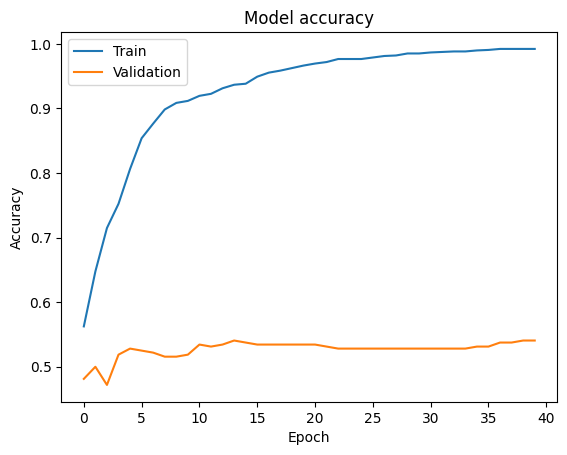

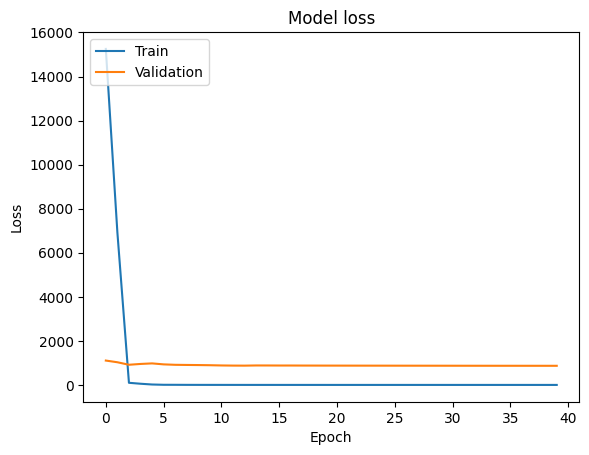

13/13 [==============================] - 0s 7ms/step - loss: 736.0074 - accuracy: 0.6000
Test accuracy: 0.6000000238418579
13/13 [==============================] - 0s 7ms/step


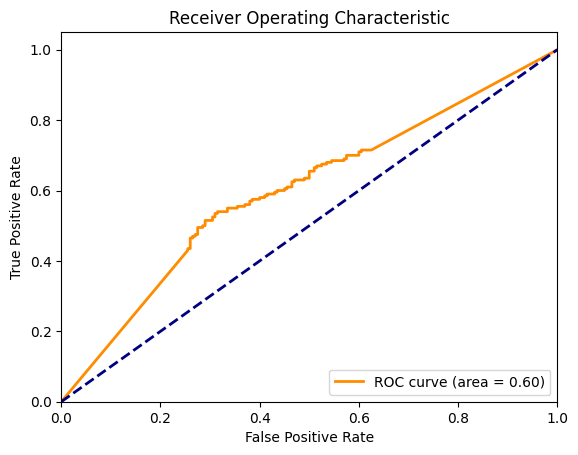

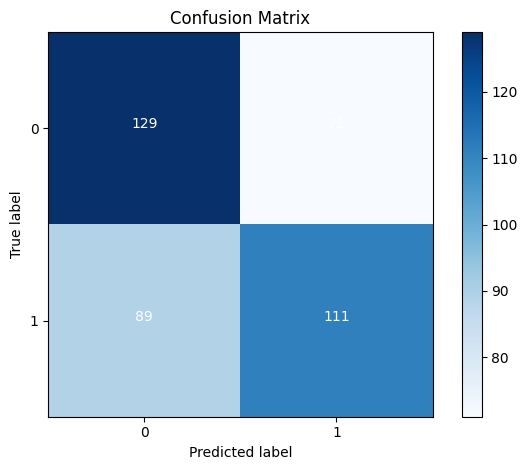

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       200
           1       0.61      0.56      0.58       200

    accuracy                           0.60       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.60      0.60      0.60       400



In [57]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras import models, layers
# Define the input shape
input_shape = (3, 12000)

# Create a deeper CNN model



# Define the input shape
input_shape = (3, 12000)

#
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(1),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(norm_data_t, trace_train, epochs=40, batch_size=32, validation_data=(norm_data_v, trace_val))
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(norm_data_ts, trace_test)
print('Test accuracy:', test_acc)

# Make predictions on test data
predictions = model.predict(norm_data_ts)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(trace_test, predictions)
roc_auc = roc_auc_score(trace_test, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(trace_test, binary_predictions)

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.tight_layout()

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# Print classification report
class_report = classification_report(trace_test, binary_predictions)
print("Classification Report:")
print(class_report)



Epoch 1/40
160/160 [==============================] - 3s 14ms/step - loss: 7122.2085 - accuracy: 0.4883 - val_loss: 456.3871 - val_accuracy: 0.5250
Epoch 2/40
160/160 [==============================] - 2s 13ms/step - loss: 1460.6350 - accuracy: 0.6414 - val_loss: 530.6928 - val_accuracy: 0.5125
Epoch 3/40
160/160 [==============================] - 2s 13ms/step - loss: 188.4646 - accuracy: 0.6953 - val_loss: 572.1420 - val_accuracy: 0.5312
Epoch 4/40
160/160 [==============================] - 2s 14ms/step - loss: 59.4195 - accuracy: 0.7805 - val_loss: 523.7074 - val_accuracy: 0.5344
Epoch 5/40
160/160 [==============================] - 2s 13ms/step - loss: 48.9431 - accuracy: 0.8148 - val_loss: 517.7753 - val_accuracy: 0.5406
Epoch 6/40
160/160 [==============================] - 2s 14ms/step - loss: 38.9462 - accuracy: 0.8313 - val_loss: 423.2878 - val_accuracy: 0.5594
Epoch 7/40
160/160 [==============================] - 2s 13ms/step - loss: 27.2807 - accuracy: 0.8547 - val_loss: 427.2

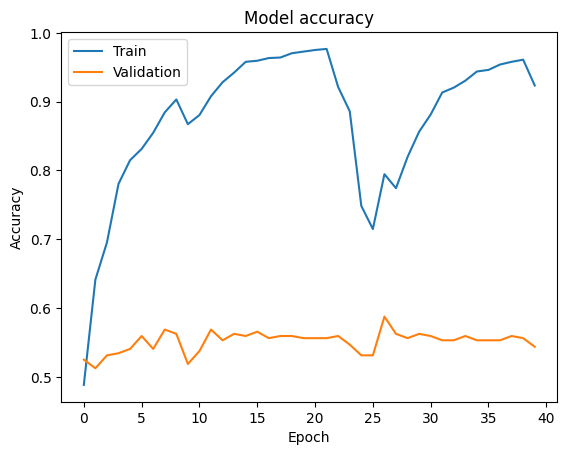

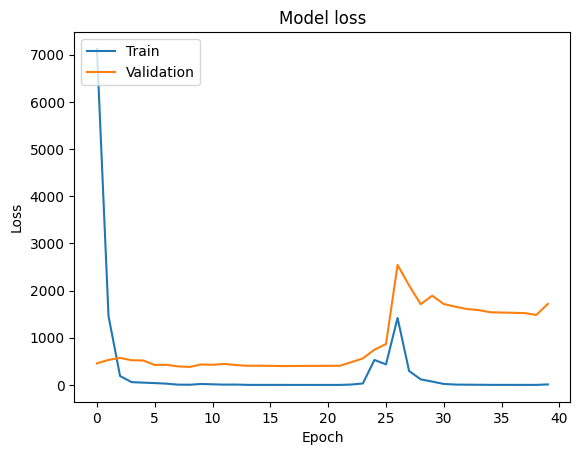

13/13 [==============================] - 0s 5ms/step - loss: 2113.2476 - accuracy: 0.5750
Test accuracy: 0.574999988079071
13/13 [==============================] - 0s 5ms/step


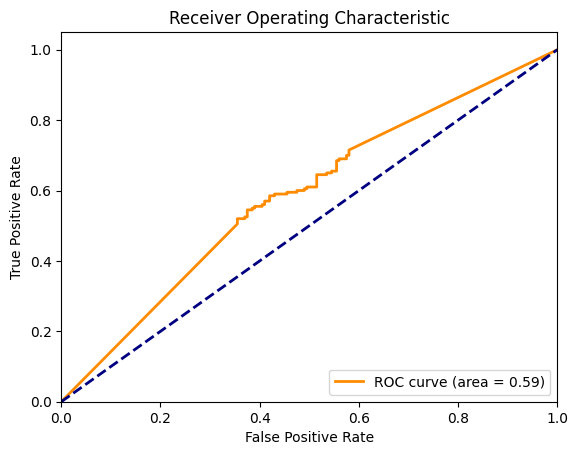

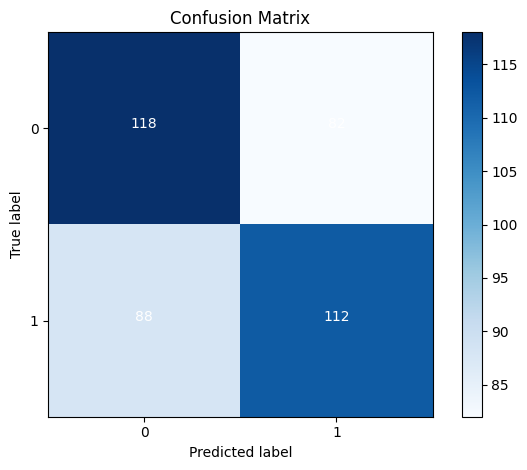

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       200
           1       0.58      0.56      0.57       200

    accuracy                           0.57       400
   macro avg       0.58      0.57      0.57       400
weighted avg       0.58      0.57      0.57       400



In [31]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

# Define the input shape
input_shape = (3, 12000)

# Create a simple CNN model
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(1),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(norm_data_t, trace_train, epochs=40, batch_size=64, validation_data=(norm_data_v, trace_val))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(norm_data_ts, trace_test)
print('Test accuracy:', test_acc)

# Make predictions on test data
predictions = model.predict(norm_data_ts)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(trace_test, predictions)
roc_auc = roc_auc_score(trace_test, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(trace_test, binary_predictions)

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.tight_layout()

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# Print classification report
class_report = classification_report(trace_test, binary_predictions)
print("Classification Report:")
print(class_report)

In [ ]:
######################################################